In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
import turing as tu
from turing.utils import *
import turing.loss_functions as tu_loss

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_RT = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]]}
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    return ret



In [3]:
model_params_1 = {'training_data_size': T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(**model_params_1)
lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

In [5]:
pinn = tu.NN(layers, lb, ub)
loss_stack_1 = [tu_loss.Observations(pinn, obs_X, obs_Y, init_loss_weight = 1.0),
                tu_loss.ASDM(pinn, pde_X)
               ]
model_1 = tu.TINN(pinn, loss_stack_1, optimizer=keras.optimizers.Adam())

In [6]:
arr_losses_1, samples_params_1, samples_grads_1 = \
         model_1.train(10000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:58547.08
Loss_observations:33965.46301270 
Loss_ASDM:24581.62170410 sigma_a:0:0.98471045, sigma_s:0:0.98408085, rho_a:0:0.98598903, rho_s:0:1.01374912, mu_a:0:1.01334870, kappa_a:0:0.99155128
Time:7.41

Epoch: 100, loss:4291.10
Loss_observations:4282.81575012 
Loss_ASDM:8.28821918 sigma_a:0:0.79494798, sigma_s:0:0.83202565, rho_a:0:0.72619772, rho_s:0:1.29630125, mu_a:0:1.26058698, kappa_a:0:0.98182505
Time:164.07

Epoch: 200, loss:4289.13
Loss_observations:4281.11697388 
Loss_ASDM:8.01630250 sigma_a:0:0.79103518, sigma_s:0:0.82453448, rho_a:0:0.72639906, rho_s:0:1.29166865, mu_a:0:1.25657630, kappa_a:0:0.99108231
Time:167.54

Epoch: 300, loss:4286.55
Loss_observations:4279.62168884 
Loss_ASDM:6.92789188 sigma_a:0:0.78455168, sigma_s:0:0.81292069, rho_a:0:0.72878069, rho_s:0:1.28076541, mu_a:0:1.24568880, kappa_a:0:1.00619912
Time:169.21

Epoch: 400, loss:4277.45
Loss_observations:4268.86766052 
Loss_ASDM:8.58307397 sigma_a:0:0.76541585, sigma_s:0:0.79378122, rho_a:0:0.7

Epoch: 3800, loss:164.08
Loss_observations:79.96915817 
Loss_ASDM:84.11508608 sigma_a:0:0.18513367, sigma_s:0:0.06620487, rho_a:0:1.93764436, rho_s:0:0.06094332, mu_a:0:2.24868774, kappa_a:0:0.19723354
Time:184.48

Epoch: 3900, loss:162.99
Loss_observations:79.98491001 
Loss_ASDM:83.00305462 sigma_a:0:0.18805531, sigma_s:0:0.06639432, rho_a:0:1.96455598, rho_s:0:0.06183121, mu_a:0:2.27796817, kappa_a:0:0.19817263
Time:185.16

Epoch: 4000, loss:158.77
Loss_observations:77.15897799 
Loss_ASDM:81.61370754 sigma_a:0:0.19107343, sigma_s:0:0.06625088, rho_a:0:1.98990893, rho_s:0:0.06275611, mu_a:0:2.30576587, kappa_a:0:0.19953404
Time:186.73

Epoch: 4100, loss:154.69
Loss_observations:75.76533031 
Loss_ASDM:78.92691231 sigma_a:0:0.19455916, sigma_s:0:0.06668168, rho_a:0:2.01477790, rho_s:0:0.06311208, mu_a:0:2.33294487, kappa_a:0:0.20034304
Time:186.16

Epoch: 4200, loss:150.94
Loss_observations:74.68318796 
Loss_ASDM:76.26172829 sigma_a:0:0.19743308, sigma_s:0:0.06701085, rho_a:0:2.03929520

Epoch: 7700, loss:67.21
Loss_observations:37.93881035 
Loss_ASDM:29.26872325 sigma_a:0:0.21619424, sigma_s:0:0.08122791, rho_a:0:2.62390161, rho_s:0:0.07764550, mu_a:0:2.87710047, kappa_a:0:0.24070917
Time:185.67

Epoch: 7800, loss:65.77
Loss_observations:36.42805624 
Loss_ASDM:29.34177887 sigma_a:0:0.21564424, sigma_s:0:0.08080930, rho_a:0:2.63118196, rho_s:0:0.07864865, mu_a:0:2.88328815, kappa_a:0:0.24110514
Time:185.09

Epoch: 7900, loss:64.14
Loss_observations:35.78219295 
Loss_ASDM:28.35915565 sigma_a:0:0.21543901, sigma_s:0:0.08181795, rho_a:0:2.63796520, rho_s:0:0.07801193, mu_a:0:2.88884950, kappa_a:0:0.24163963
Time:185.44

Epoch: 8000, loss:64.25
Loss_observations:35.98480678 
Loss_ASDM:28.26517737 sigma_a:0:0.21550502, sigma_s:0:0.08191977, rho_a:0:2.64430285, rho_s:0:0.07892623, mu_a:0:2.89398456, kappa_a:0:0.24207862
Time:186.10

Epoch: 8100, loss:62.17
Loss_observations:35.12335956 
Loss_ASDM:27.04533231 sigma_a:0:0.21556790, sigma_s:0:0.08187511, rho_a:0:2.65007901, rho

In [9]:
loss_stack_1[1].loss_weight

0.17402883487449147

In [9]:
arr_losses_1, samples_params_1, samples_grads_1 = \
         model_1.train(3000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=False,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:350241.75
Loss_observations:324837.74853516 
Loss_ASDM:25404.01434326 sigma_a:0:0.98454815, sigma_s:0:0.98409212, rho_a:0:0.98660004, rho_s:0:1.01298809, mu_a:0:1.01253605, kappa_a:0:0.99371088
Time:1.89

Epoch: 100, loss:43487.04
Loss_observations:43477.11865234 
Loss_ASDM:9.91631711 sigma_a:0:0.77717835, sigma_s:0:0.81001151, rho_a:0:0.74989986, rho_s:0:1.28945374, mu_a:0:1.25295377, kappa_a:0:1.01924467
Time:63.81

Epoch: 200, loss:43582.39
Loss_observations:43563.89965820 
Loss_ASDM:18.49461335 sigma_a:0:0.77144259, sigma_s:0:0.79904699, rho_a:0:0.75217640, rho_s:0:1.28197205, mu_a:0:1.24633479, kappa_a:0:1.03252232
Time:65.06

Epoch: 300, loss:43608.27
Loss_observations:43587.00976562 
Loss_ASDM:21.26597497 sigma_a:0:0.75896853, sigma_s:0:0.78061426, rho_a:0:0.75635016, rho_s:0:1.26568973, mu_a:0:1.23211658, kappa_a:0:1.05663717
Time:65.40

Epoch: 400, loss:43484.17
Loss_observations:43475.20288086 
Loss_ASDM:8.96911034 sigma_a:0:0.73884821, sigma_s:0:0.75791055, rh

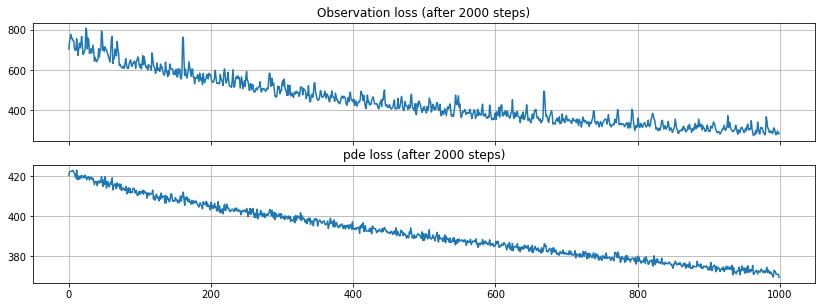

In [17]:
start = 2000
W_n = len(layers)-1
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)

_ = plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.title(f"Observation loss (after {start} steps)")
plt.plot(arr_losses_1[start:,0])
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.grid()
plt.subplot(4,1,2)
plt.title(f"pde loss (after {start} steps)")
plt.plot(arr_losses_1[start:,1])
plt.grid()
plt.show()

In [18]:
arr_losses_2, samples_params_2, samples_grads_2 = \
         model_1.train(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=False,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:668.53
Loss_observations:296.48621559 
Loss_ASDM:372.03947258 sigma_a:0:0.05406018, sigma_s:0:0.08470893, rho_a:0:1.98740351, rho_s:0:0.08286175, mu_a:0:2.05707550, kappa_a:0:0.24378011
Time:0.57

Epoch: 100, loss:646.49
Loss_observations:277.88595772 
Loss_ASDM:368.60891151 sigma_a:0:0.06271428, sigma_s:0:0.08496193, rho_a:0:2.02637529, rho_s:0:0.08318087, mu_a:0:2.10595918, kappa_a:0:0.24316454
Time:68.19

Epoch: 200, loss:641.94
Loss_observations:274.37158298 
Loss_ASDM:367.56389236 sigma_a:0:0.07298782, sigma_s:0:0.08414017, rho_a:0:2.06490397, rho_s:0:0.08319069, mu_a:0:2.15422416, kappa_a:0:0.24253620
Time:68.81

Epoch: 300, loss:607.66
Loss_observations:239.89317417 
Loss_ASDM:367.76502419 sigma_a:0:0.08176825, sigma_s:0:0.08523048, rho_a:0:2.10355973, rho_s:0:0.08169910, mu_a:0:2.20539045, kappa_a:0:0.24274464
Time:67.91

Epoch: 400, loss:612.75
Loss_observations:245.05352974 
Loss_ASDM:367.69760132 sigma_a:0:0.09131055, sigma_s:0:0.08403873, rho_a:0:2.14370465, 

In [19]:
arr_losses_3, samples_params_3, samples_grads_3 = \
         model_1.train(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=False,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:641.18
Loss_observations:188.28607082 
Loss_ASDM:452.89105606 sigma_a:0:0.21767862, sigma_s:0:0.08390062, rho_a:0:2.74320197, rho_s:0:0.08226303, mu_a:0:2.98338318, kappa_a:0:0.24286780
Time:0.62

Epoch: 100, loss:659.64
Loss_observations:191.20951843 
Loss_ASDM:468.42975616 sigma_a:0:0.22496118, sigma_s:0:0.08373773, rho_a:0:2.78143573, rho_s:0:0.08145329, mu_a:0:3.02948999, kappa_a:0:0.24294622
Time:67.89

Epoch: 200, loss:670.09
Loss_observations:187.56575680 
Loss_ASDM:482.52276421 sigma_a:0:0.23309775, sigma_s:0:0.08239825, rho_a:0:2.81929636, rho_s:0:0.08148652, mu_a:0:3.07589769, kappa_a:0:0.24322562
Time:67.91

Epoch: 300, loss:708.78
Loss_observations:206.83224201 
Loss_ASDM:501.95046997 sigma_a:0:0.24051102, sigma_s:0:0.08250336, rho_a:0:2.85680199, rho_s:0:0.08020736, mu_a:0:3.12045693, kappa_a:0:0.24316894
Time:67.95

Epoch: 400, loss:714.45
Loss_observations:194.25161648 
Loss_ASDM:520.19438934 sigma_a:0:0.24674076, sigma_s:0:0.08213172, rho_a:0:2.89251137, 

In [20]:
arr_losses_3, samples_params_3, samples_grads_3 = \
         model_1.train(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=False,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:810.53
Loss_observations:207.52843571 
Loss_ASDM:602.99863052 sigma_a:0:0.28926861, sigma_s:0:0.07729247, rho_a:0:3.08533978, rho_s:0:0.07478802, mu_a:0:3.40016913, kappa_a:0:0.24374661
Time:0.54

Epoch: 100, loss:825.31
Loss_observations:205.13641548 
Loss_ASDM:620.17515373 sigma_a:0:0.29644859, sigma_s:0:0.07518971, rho_a:0:3.11545229, rho_s:0:0.07553366, mu_a:0:3.43798232, kappa_a:0:0.24386860
Time:67.84

Epoch: 200, loss:833.56
Loss_observations:201.61006451 
Loss_ASDM:631.95472717 sigma_a:0:0.30252454, sigma_s:0:0.07493689, rho_a:0:3.14327836, rho_s:0:0.07454465, mu_a:0:3.47241306, kappa_a:0:0.24334168
Time:68.40

Epoch: 300, loss:833.64
Loss_observations:197.62749863 
Loss_ASDM:636.01024246 sigma_a:0:0.30950508, sigma_s:0:0.07450573, rho_a:0:3.17047334, rho_s:0:0.07459330, mu_a:0:3.50542784, kappa_a:0:0.24374974
Time:67.67

Epoch: 400, loss:851.04
Loss_observations:207.14487267 
Loss_ASDM:643.89145470 sigma_a:0:0.31572381, sigma_s:0:0.07400574, rho_a:0:3.19665122, 

In [22]:
arr_losses = np.r_[arr_losses_1, arr_losses_2, arr_losses_3]

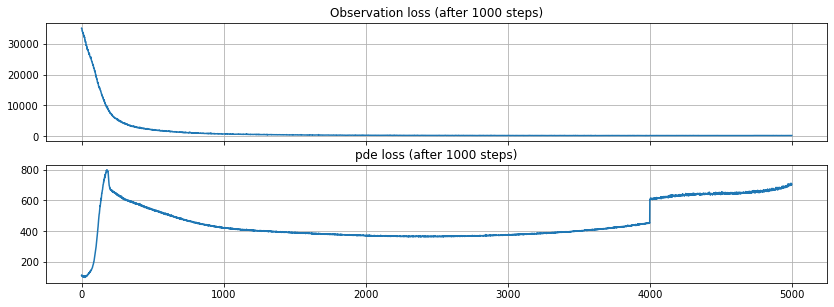

In [28]:
start = 1000#2000
W_n = len(layers)-1
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)

_ = plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.title(f"Observation loss (after {start} steps)")
plt.plot(arr_losses[start:,0])
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.grid()
plt.subplot(4,1,2)
plt.title(f"pde loss (after {start} steps)")
plt.plot(arr_losses[start:,1])
plt.grid()
plt.show()

In [12]:
arr_losses_1, samples_params_1, samples_grads_1 = \
         model_1.train(6000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:3277974.75
Loss_observations:3252595.25781250 
Loss_ASDM:25379.27252197 sigma_a:0:0.98455614, sigma_s:0:0.98408872, rho_a:0:0.98607934, rho_s:0:1.01371741, mu_a:0:1.01269138, kappa_a:0:0.99334162
Time:6.68

Epoch: 100, loss:433117.38
Loss_observations:433097.55078125 
Loss_ASDM:19.85487455 sigma_a:0:0.77695978, sigma_s:0:0.80845910, rho_a:0:0.75142276, rho_s:0:1.28602684, mu_a:0:1.25103188, kappa_a:0:1.02038193
Time:165.12

Epoch: 200, loss:431622.62
Loss_observations:431582.50585938 
Loss_ASDM:40.08369792 sigma_a:0:0.76416308, sigma_s:0:0.78616261, rho_a:0:0.75952381, rho_s:0:1.26888144, mu_a:0:1.23590684, kappa_a:0:1.05007017
Time:167.44

Epoch: 300, loss:430638.00
Loss_observations:430600.84570312 
Loss_ASDM:37.13485456 sigma_a:0:0.71842623, sigma_s:0:0.74475694, rho_a:0:0.77608383, rho_s:0:1.23068571, mu_a:0:1.19168639, kappa_a:0:1.09311140
Time:168.84

Epoch: 400, loss:429962.75
Loss_observations:429928.08203125 
Loss_ASDM:34.67142034 sigma_a:0:0.63754690, sigma_s:0

In [14]:
loss_stack_1[1].loss_weight

1369.8374050465136

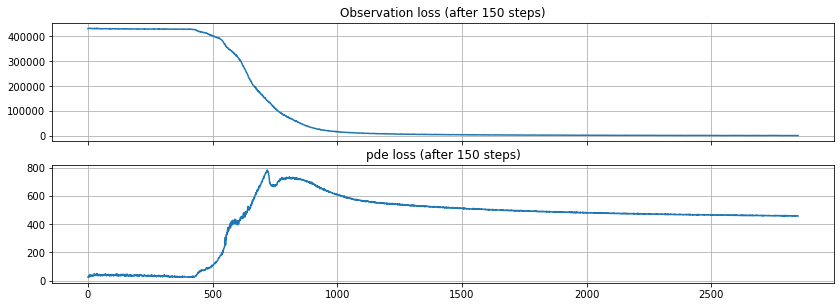

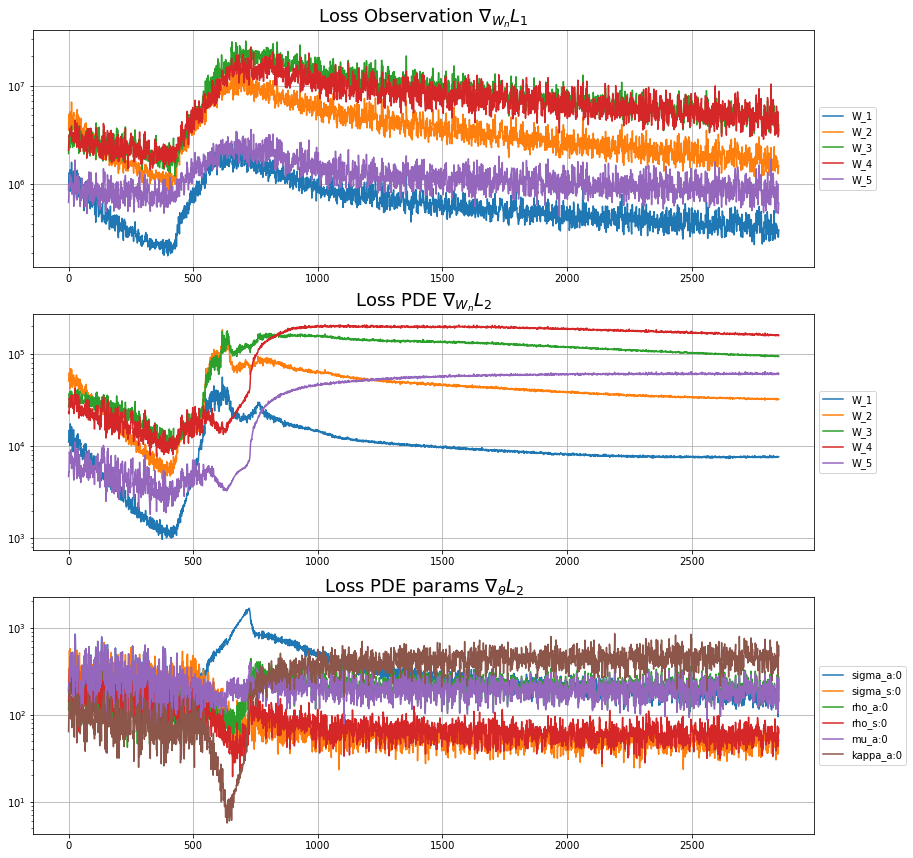

In [16]:
start = 150
W_n = len(layers)-1
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)

_ = plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.title(f"Observation loss (after {start} steps)")
plt.plot(arr_losses_1[start:,0])
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.grid()
plt.subplot(4,1,2)
plt.title(f"pde loss (after {start} steps)")
plt.plot(arr_losses_1[start:,1])
plt.grid()
plt.show()

_ = plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.title(r"Loss Observation $\nabla_{W_n} L_1$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,0,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,2)
plt.title(r"Loss PDE $\nabla_{W_n} L_2$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,1,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,3)
plt.title(r"Loss PDE params $\nabla_{\theta} L_2$", fontsize=18)
for j in range(params_len):
    plt.plot(samples_grads_1[start:,1,j+2*W_n], label=f"{param_names[j]}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [6]:
arr_losses_1, samples_params_1, samples_grads_1 = \
         model_1.train(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:349195.81
Loss_observations:323694.74414062 
Loss_ASDM:25501.04864502 sigma_a:0:0.98452938, sigma_s:0:0.98409230, rho_a:0:0.98609602, rho_s:0:1.01133633, mu_a:0:1.01298940, kappa_a:0:0.99155045
Time:7.19

Epoch: 100, loss:43284.07
Loss_observations:43261.25219727 
Loss_ASDM:22.82247704 sigma_a:0:0.77704376, sigma_s:0:0.81084532, rho_a:0:0.75409997, rho_s:0:1.28394282, mu_a:0:1.24894726, kappa_a:0:1.01755452
Time:164.95

Epoch: 200, loss:43290.03
Loss_observations:43271.68969727 
Loss_ASDM:18.34233248 sigma_a:0:0.76602262, sigma_s:0:0.79820222, rho_a:0:0.75717151, rho_s:0:1.27343452, mu_a:0:1.23772478, kappa_a:0:1.03121281
Time:166.83

Epoch: 300, loss:43281.24
Loss_observations:43264.51708984 
Loss_ASDM:16.72176385 sigma_a:0:0.74350226, sigma_s:0:0.77780128, rho_a:0:0.76357806, rho_s:0:1.25279272, mu_a:0:1.21324706, kappa_a:0:1.05252099
Time:166.62

Epoch: 400, loss:43269.92
Loss_observations:43254.40551758 
Loss_ASDM:15.51174015 sigma_a:0:0.70264965, sigma_s:0:0.7505891

In [13]:
loss_stack_1[1].loss_weight

3.586330340909571

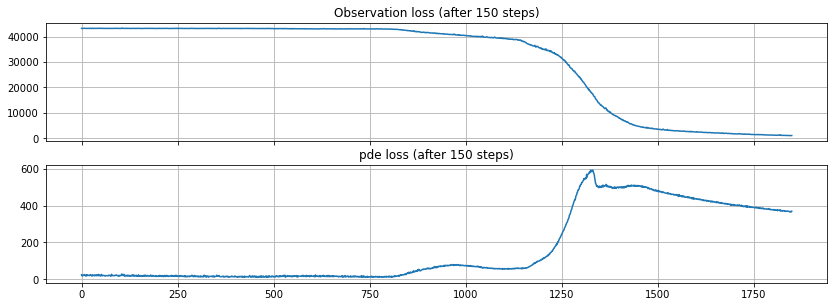

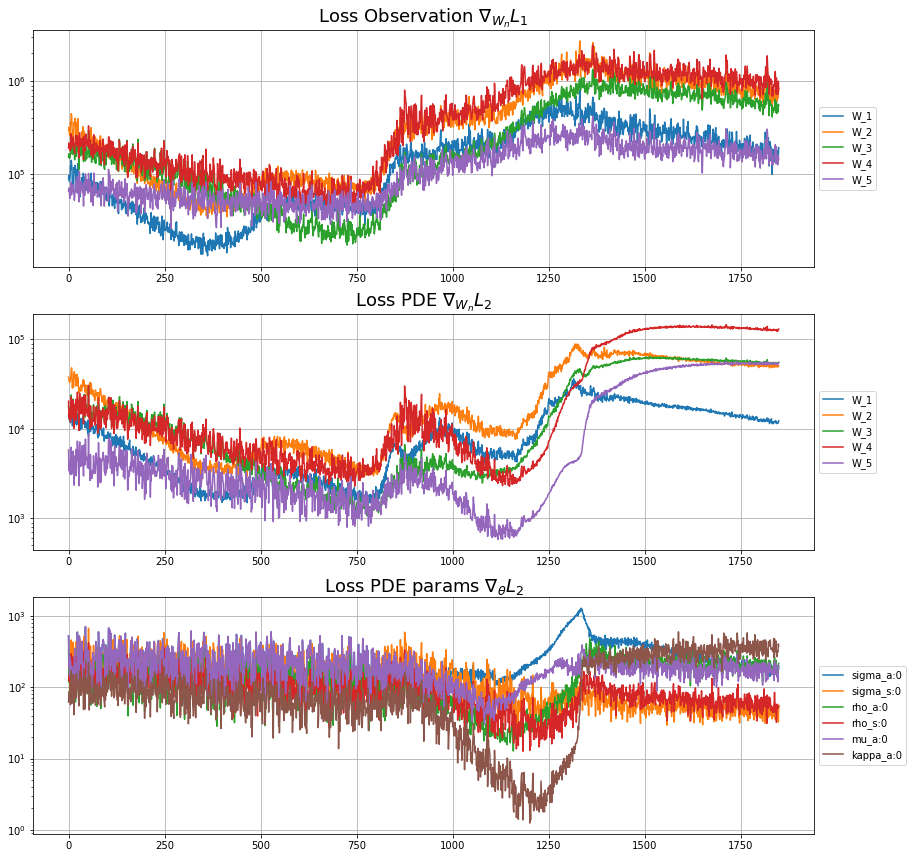

In [20]:
start = 150
W_n = len(layers)-1
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)

_ = plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.title(f"Observation loss (after {start} steps)")
plt.plot(arr_losses_1[start:,0])
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.grid()
plt.subplot(4,1,2)
plt.title(f"pde loss (after {start} steps)")
plt.plot(arr_losses_1[start:,1])
plt.grid()
plt.show()

_ = plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.title(r"Loss Observation $\nabla_{W_n} L_1$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,0,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,2)
plt.title(r"Loss PDE $\nabla_{W_n} L_2$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,1,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,3)
plt.title(r"Loss PDE params $\nabla_{\theta} L_2$", fontsize=18)
for j in range(params_len):
    plt.plot(samples_grads_1[start:,1,j+2*W_n], label=f"{param_names[j]}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
arr_losses_2, samples_params_2, samples_grads_2 = \
         model_1.train(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:1346.80
Loss_observations:980.53830719 
Loss_ASDM:366.26478195 sigma_a:0:0.00000000, sigma_s:0:0.08078753, rho_a:0:1.35459065, rho_s:0:0.07723080, mu_a:0:1.41062355, kappa_a:0:0.21327154
Time:1.65

Epoch: 100, loss:1121.35
Loss_observations:773.00843811 
Loss_ASDM:348.34048843 sigma_a:0:0.00000000, sigma_s:0:0.08099674, rho_a:0:1.44376361, rho_s:0:0.07782239, mu_a:0:1.48733521, kappa_a:0:0.22142267
Time:179.78

Epoch: 200, loss:1003.23
Loss_observations:663.94261932 
Loss_ASDM:339.29100800 sigma_a:0:0.00000000, sigma_s:0:0.08096622, rho_a:0:1.51010239, rho_s:0:0.07928046, mu_a:0:1.54667258, kappa_a:0:0.22943196
Time:180.75

Epoch: 300, loss:899.36
Loss_observations:568.98163605 
Loss_ASDM:330.37536049 sigma_a:0:0.00002373, sigma_s:0:0.08122292, rho_a:0:1.56184876, rho_s:0:0.08066993, mu_a:0:1.59115541, kappa_a:0:0.23436622
Time:182.71

Epoch: 400, loss:823.43
Loss_observations:500.90289497 
Loss_ASDM:322.52708817 sigma_a:0:0.00105805, sigma_s:0:0.08159126, rho_a:0:1.6040

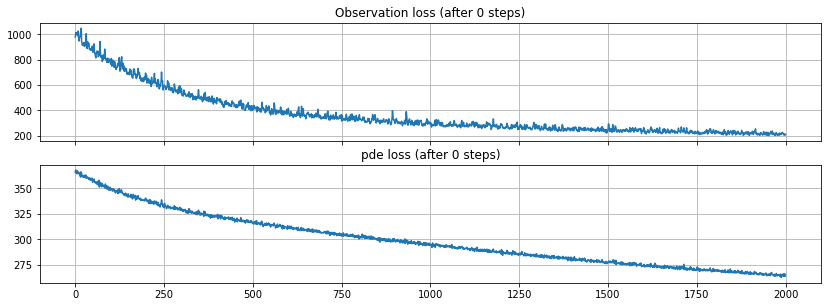

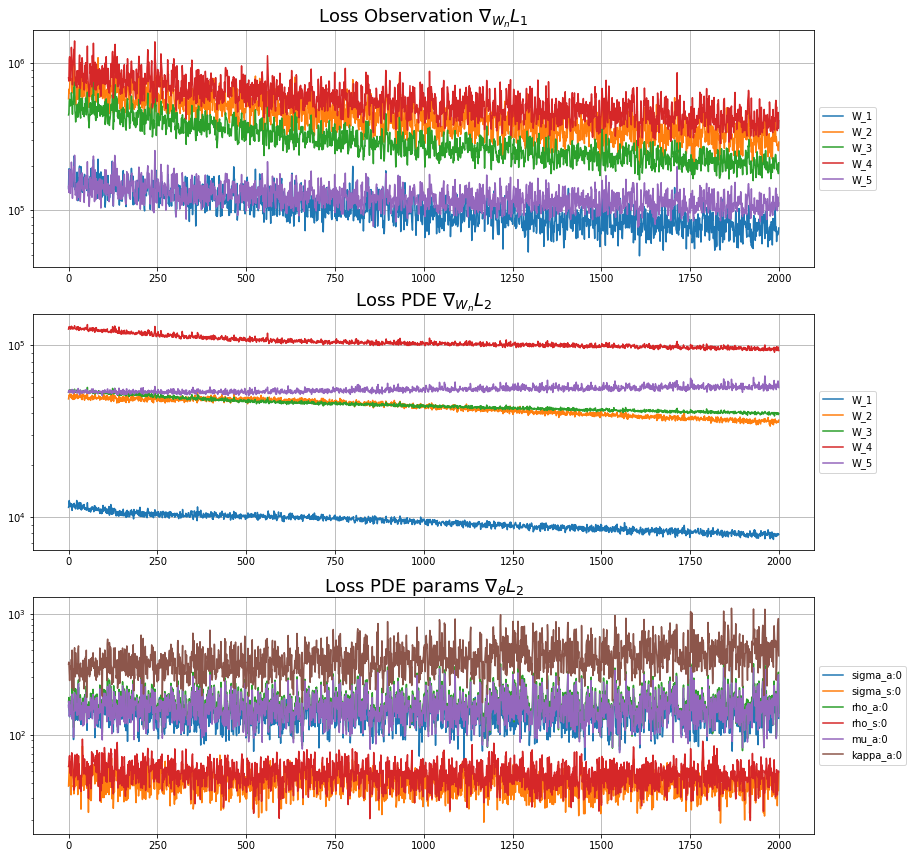

In [23]:
start = 0
W_n = len(layers)-1
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)

_ = plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.title(f"Observation loss (after {start} steps)")
plt.plot(arr_losses_2[start:,0])
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.grid()
plt.subplot(4,1,2)
plt.title(f"pde loss (after {start} steps)")
plt.plot(arr_losses_2[start:,1])
plt.grid()
plt.show()

_ = plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.title(r"Loss Observation $\nabla_{W_n} L_1$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_2[start:,0,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,2)
plt.title(r"Loss PDE $\nabla_{W_n} L_2$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_2[start:,1,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,3)
plt.title(r"Loss PDE params $\nabla_{\theta} L_2$", fontsize=18)
for j in range(params_len):
    plt.plot(samples_grads_2[start:,1,j+2*W_n], label=f"{param_names[j]}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
pinn_2 = pinn.copy()
loss_stack_2 = [tu_loss.Observations(pinn_2, obs_X, obs_Y),
                tu_loss.ASDM(pinn_2, pde_X, init_loss_weight = 10.0)
        ]
model_2 = tu.TINN(pinn_2, 
                  loss_stack_2, 
                  optimizer=keras.optimizers.SGD(learning_rate=1e-6),            
                  fixed_pinn=True)

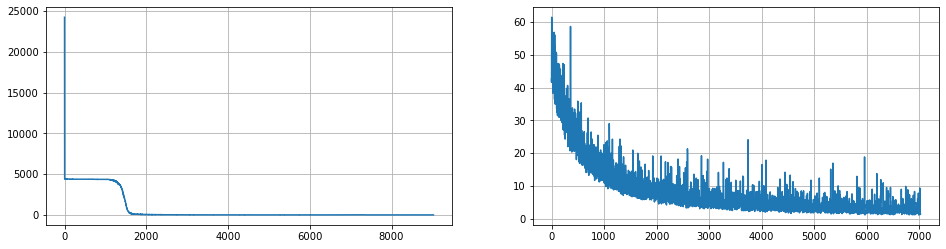

In [38]:
_ = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(arr_losses_1)
plt.grid()
plt.subplot(1,2,2)
plt.plot(arr_losses_1[2000:])
plt.grid()
plt.show()

In [8]:
arr_losses_2, samples_params_2 , _ = \
         model_2.train(10000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:100369.48
Loss_observations:0.86156464 
Loss_ASDM:100368.61035156 sigma_a:0:0.86136246, sigma_s:0:0.87753356, rho_a:0:0.95984089, rho_s:0:1.04868138, mu_a:0:1.06768703, kappa_a:0:0.98725414
Time:1.94

Epoch: 100, loss:10914.70
Loss_observations:0.86156465 
Loss_ASDM:10913.83355713 sigma_a:0:0.00000000, sigma_s:0:0.19190460, rho_a:0:1.08247423, rho_s:0:0.27763546, mu_a:0:0.65057892, kappa_a:0:0.68747681
Time:61.70

Epoch: 200, loss:6377.55
Loss_observations:0.86156464 
Loss_ASDM:6376.68511963 sigma_a:0:0.00000000, sigma_s:0:0.09304778, rho_a:0:0.96100169, rho_s:0:0.08662342, mu_a:0:0.99144202, kappa_a:0:0.19867246
Time:61.79

Epoch: 300, loss:6145.75
Loss_observations:0.86156463 
Loss_ASDM:6144.88369751 sigma_a:0:0.00000000, sigma_s:0:0.08403611, rho_a:0:1.02484691, rho_s:0:0.07673109, mu_a:0:1.10661089, kappa_a:0:0.17560725
Time:62.74

Epoch: 400, loss:6032.17
Loss_observations:0.86156461 
Loss_ASDM:6031.30328369 sigma_a:0:0.00000000, sigma_s:0:0.08448532, rho_a:0:1.1036

Epoch: 3800, loss:5595.94
Loss_observations:0.86156464 
Loss_ASDM:5595.08026123 sigma_a:0:0.00006596, sigma_s:0:0.08776725, rho_a:0:1.76062429, rho_s:0:0.08856078, mu_a:0:1.74859536, kappa_a:0:0.25657621
Time:64.92

Epoch: 3900, loss:5596.58
Loss_observations:0.86156463 
Loss_ASDM:5595.71820068 sigma_a:0:0.00029480, sigma_s:0:0.08773234, rho_a:0:1.76274979, rho_s:0:0.08863015, mu_a:0:1.75015998, kappa_a:0:0.25622791
Time:65.05

Epoch: 4000, loss:5597.03
Loss_observations:0.86156464 
Loss_ASDM:5596.17111206 sigma_a:0:0.00061092, sigma_s:0:0.08771957, rho_a:0:1.76465750, rho_s:0:0.08866557, mu_a:0:1.75168061, kappa_a:0:0.25588331
Time:65.69

Epoch: 4100, loss:5596.49
Loss_observations:0.86156463 
Loss_ASDM:5595.62902832 sigma_a:0:0.00102556, sigma_s:0:0.08770778, rho_a:0:1.76642776, rho_s:0:0.08869451, mu_a:0:1.75315630, kappa_a:0:0.25541291
Time:65.91

Epoch: 4200, loss:5596.49
Loss_observations:0.86156464 
Loss_ASDM:5595.62942505 sigma_a:0:0.00108910, sigma_s:0:0.08776353, rho_a:0:1.76

Epoch: 7600, loss:5596.07
Loss_observations:0.86156463 
Loss_ASDM:5595.20639038 sigma_a:0:0.00781554, sigma_s:0:0.08773986, rho_a:0:1.79721200, rho_s:0:0.08862969, mu_a:0:1.79124594, kappa_a:0:0.25564945
Time:67.84

Epoch: 7700, loss:5595.50
Loss_observations:0.86156464 
Loss_ASDM:5594.63510132 sigma_a:0:0.00801780, sigma_s:0:0.08769208, rho_a:0:1.79778373, rho_s:0:0.08868089, mu_a:0:1.79178262, kappa_a:0:0.25551349
Time:66.88

Epoch: 7800, loss:5596.95
Loss_observations:0.86156465 
Loss_ASDM:5596.08395386 sigma_a:0:0.00791455, sigma_s:0:0.08773150, rho_a:0:1.79803169, rho_s:0:0.08864298, mu_a:0:1.79260778, kappa_a:0:0.25602689
Time:67.72

Epoch: 7900, loss:5595.92
Loss_observations:0.86156464 
Loss_ASDM:5595.05990601 sigma_a:0:0.00811460, sigma_s:0:0.08772573, rho_a:0:1.79861808, rho_s:0:0.08864274, mu_a:0:1.79307032, kappa_a:0:0.25576147
Time:66.88

Epoch: 8000, loss:5596.55
Loss_observations:0.86156463 
Loss_ASDM:5595.68673706 sigma_a:0:0.00814114, sigma_s:0:0.08774546, rho_a:0:1.79

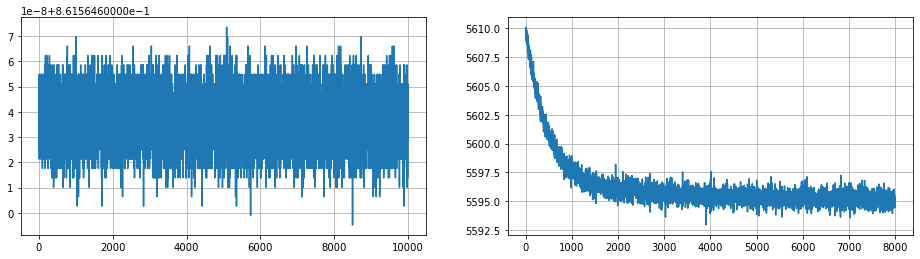

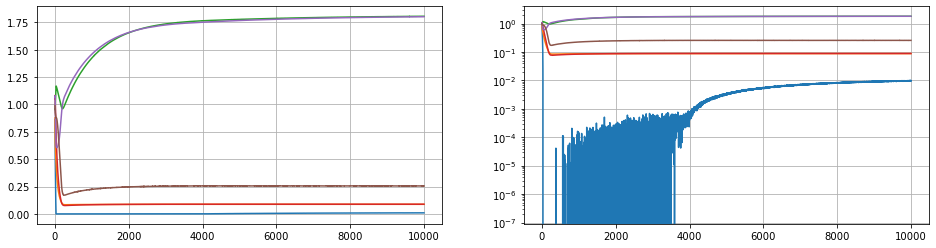

In [49]:
_ = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(arr_losses_2[:,0])
plt.grid()
plt.subplot(1,2,2)
plt.plot(arr_losses_2[2000:,1])
plt.grid()
plt.show()

_ = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
for i in range(samples_params_2.shape[1]):
    plt.plot(samples_params_2[:,i])
plt.grid()
plt.subplot(1,2,2)
for i in range(samples_params_2.shape[1]):
    plt.plot(samples_params_2[:,i])
plt.yscale('log')
plt.grid()

plt.show()

In [53]:
pinn_5 = pinn_2.copy()
loss_stack_5 = [tu_loss.ASDM(pinn_5, pde_X, init_loss_weight = 10.0,
                             sigma_a = loss_stack_2[1].sigma_a.numpy()[0],
                             sigma_s = loss_stack_2[1].sigma_s.numpy()[0],
                             mu_a = loss_stack_2[1].mu_a.numpy()[0],
                             rho_a = loss_stack_2[1].rho_a.numpy()[0],
                             rho_s = loss_stack_2[1].rho_s.numpy()[0],
                             kappa_a = loss_stack_2[1].kappa_a.numpy()[0])
        ]
model_5 = tu.TINN(pinn_5, 
                  loss_stack_5, 
                  optimizer=keras.optimizers.Adam(),            
                  fixed_pinn=False,
                  fixed_loss_params=True)

In [54]:
arr_losses_5, samples_params_5, _ = \
         model_5.train(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:7164.23
Loss_ASDM:7164.22824097 sigma_a:0:0.00976494, sigma_s:0:0.08769540, rho_a:0:1.80587399, rho_s:0:0.08867563, mu_a:0:1.80195808, kappa_a:0:0.25567263
Time:1.67

Epoch: 100, loss:1606046.25
Loss_ASDM:1606046.31152344 sigma_a:0:0.00976494, sigma_s:0:0.08769540, rho_a:0:1.80587399, rho_s:0:0.08867563, mu_a:0:1.80195808, kappa_a:0:0.25567263
Time:66.68

Epoch: 200, loss:6361408.00
Loss_ASDM:6361407.76367188 sigma_a:0:0.00976494, sigma_s:0:0.08769540, rho_a:0:1.80587399, rho_s:0:0.08867563, mu_a:0:1.80195808, kappa_a:0:0.25567263
Time:67.38

Epoch: 300, loss:876342.12
Loss_ASDM:876342.08166504 sigma_a:0:0.00976494, sigma_s:0:0.08769540, rho_a:0:1.80587399, rho_s:0:0.08867563, mu_a:0:1.80195808, kappa_a:0:0.25567263
Time:68.30

Epoch: 400, loss:9041.40
Loss_ASDM:9041.40380859 sigma_a:0:0.00976494, sigma_s:0:0.08769540, rho_a:0:1.80587399, rho_s:0:0.08867563, mu_a:0:1.80195808, kappa_a:0:0.25567263
Time:68.43

Epoch: 500, loss:11581.61
Loss_ASDM:11581.60546875 sigma_a:0:0

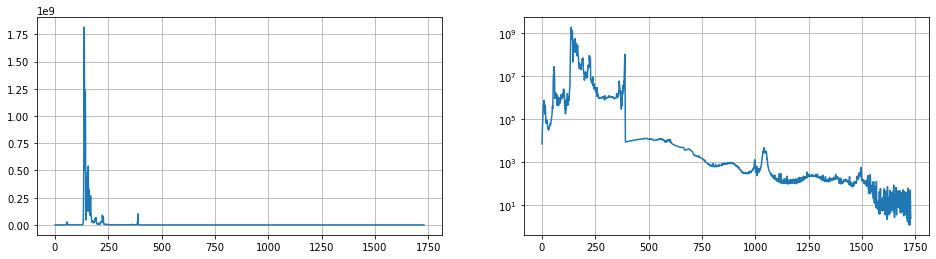

In [57]:
_ = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(arr_losses_5[:])
plt.grid()
plt.subplot(1,2,2)
plt.plot(arr_losses_5[:])
plt.yscale('log')
plt.grid()
plt.show()

In [62]:
pinn_6 = pinn_5.copy()
loss_stack_6 = [tu_loss.Observations(pinn_6, obs_X, obs_Y),
                tu_loss.ASDM(pinn_6, pde_X, init_loss_weight = 10.0,
                             sigma_a = loss_stack_2[1].sigma_a.numpy()[0],
                             sigma_s = loss_stack_2[1].sigma_s.numpy()[0],
                             mu_a = loss_stack_2[1].mu_a.numpy()[0],
                             rho_a = loss_stack_2[1].rho_a.numpy()[0],
                             rho_s = loss_stack_2[1].rho_s.numpy()[0],
                             kappa_a = loss_stack_2[1].kappa_a.numpy()[0])
        ]
model_6 = tu.TINN(pinn_6, 
                  loss_stack_6, 
                  optimizer=keras.optimizers.Adam(),            
                  fixed_pinn=False,
                  fixed_loss_params=False)

In [63]:
arr_losses_6, samples_params_6, _ = \
         model_6.train(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:5877.89
Loss_observations:4654.68157959 
Loss_ASDM:1223.21056944 sigma_a:0:0.00946773, sigma_s:0:0.08169197, rho_a:0:1.80426776, rho_s:0:0.09448843, mu_a:0:1.80276453, kappa_a:0:0.25809756
Time:2.06

Epoch: 100, loss:4171.40
Loss_observations:3985.14036560 
Loss_ASDM:186.26051712 sigma_a:0:0.01979025, sigma_s:0:0.00503706, rho_a:0:1.79275990, rho_s:0:0.00488190, mu_a:0:1.79781628, kappa_a:0:0.27246857
Time:82.22

Epoch: 200, loss:39988.79
Loss_observations:4447.00222778 
Loss_ASDM:35541.78527832 sigma_a:0:0.00314425, sigma_s:0:0.00100817, rho_a:0:1.78019106, rho_s:0:0.00000000, mu_a:0:1.80321538, kappa_a:0:0.24521656
Time:82.50

Epoch: 300, loss:5415.53
Loss_observations:5002.33856201 
Loss_ASDM:413.19135666 sigma_a:0:0.00000000, sigma_s:0:0.00038514, rho_a:0:1.90150249, rho_s:0:0.00000000, mu_a:0:1.85855973, kappa_a:0:0.02589131
Time:83.15

Epoch: 400, loss:4804.09
Loss_observations:4508.35998535 
Loss_ASDM:295.72607517 sigma_a:0:0.00000000, sigma_s:0:0.00098529, rho_a:

KeyboardInterrupt: 

In [9]:
pinn_3 = pinn_2.copy()
loss_stack_3 = [tu_loss.Observations(pinn_3,
                                     inputs_obs = dataset['obs_input'],
                                     outputs_obs = dataset['obs_output']),
                tu_loss.ASDM(pinn_3,
                             inputs_pde = dataset['pde'],
                             init_loss_weight = 1.0,
                             sigma_a = loss_stack_2[1].sigma_a.numpy()[0],
                             sigma_s = loss_stack_2[1].sigma_s.numpy()[0],
                             mu_a = loss_stack_2[1].mu_a.numpy()[0],
                             rho_a = loss_stack_2[1].rho_a.numpy()[0],
                             rho_s = loss_stack_2[1].rho_s.numpy()[0],
                             kappa_a = loss_stack_2[1].kappa_a.numpy()[0])
           ]

model_3 = tu.TINN(pinn_3, 
                  loss_stack_3, 
                  #optimizer=keras.optimizers.SGD(learning_rate=1e-6),
                  optimizer=keras.optimizers.Adam(),
                  fixed_loss_params=False,
                  fixed_pinn=False)

In [10]:
arr_losses_3, samples_params_3, _ = \
         model_3.train(10000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:685.95
Loss_observations:141.53834336 
Loss_ASDM:544.41462708 sigma_a:0:0.01019052, sigma_s:0:0.08726013, rho_a:0:1.80597115, rho_s:0:0.08897119, mu_a:0:1.80145550, kappa_a:0:0.25564095
Time:1.96

Epoch: 100, loss:41709.48
Loss_observations:5687.67428589 
Loss_ASDM:36021.80493164 sigma_a:0:0.07506263, sigma_s:0:0.00355055, rho_a:0:1.73141003, rho_s:0:0.00000000, mu_a:0:2.07084727, kappa_a:0:0.02810254
Time:72.16

Epoch: 200, loss:4587.54
Loss_observations:4389.76287842 
Loss_ASDM:197.77520180 sigma_a:0:0.08694585, sigma_s:0:0.00000000, rho_a:0:1.84036767, rho_s:0:0.00000000, mu_a:0:2.37032557, kappa_a:0:0.00449567
Time:73.61

Epoch: 300, loss:4302.02
Loss_observations:4208.07040405 
Loss_ASDM:93.94664478 sigma_a:0:0.07317448, sigma_s:0:0.00077342, rho_a:0:1.83809745, rho_s:0:0.00017752, mu_a:0:2.38252115, kappa_a:0:0.00462052
Time:73.25

Epoch: 400, loss:4316.28
Loss_observations:4299.89096069 
Loss_ASDM:16.39008760 sigma_a:0:0.04768920, sigma_s:0:0.00072631, rho_a:0:1.8

Epoch: 3800, loss:1613249.25
Loss_observations:16656.05664062 
Loss_ASDM:1596593.16796875 sigma_a:0:0.00000000, sigma_s:0:0.00000000, rho_a:0:3.47412944, rho_s:0:0.00000000, mu_a:0:3.74457574, kappa_a:0:0.00000000
Time:79.09

Epoch: 3900, loss:535167.31
Loss_observations:7184.99624634 
Loss_ASDM:527982.29394531 sigma_a:0:0.00000000, sigma_s:0:0.00002751, rho_a:0:3.54576635, rho_s:0:0.00000000, mu_a:0:3.99146199, kappa_a:0:0.00000000
Time:80.15

Epoch: 4000, loss:35024.65
Loss_observations:5555.94351196 
Loss_ASDM:29468.70935059 sigma_a:0:0.00000000, sigma_s:0:0.00000000, rho_a:0:3.55004287, rho_s:0:0.00000000, mu_a:0:4.11414528, kappa_a:0:0.00000000
Time:79.17

Epoch: 4100, loss:14165.10
Loss_observations:5005.74377441 
Loss_ASDM:9159.35336304 sigma_a:0:0.01901059, sigma_s:0:0.00000179, rho_a:0:3.54896712, rho_s:0:0.00000000, mu_a:0:4.22782803, kappa_a:0:0.00000000
Time:79.44

Epoch: 4200, loss:11437.22
Loss_observations:4902.13854980 
Loss_ASDM:6535.08216858 sigma_a:0:0.01152025, sigm

Epoch: 7600, loss:2501.01
Loss_observations:2235.93257904 
Loss_ASDM:265.07284069 sigma_a:0:0.92828548, sigma_s:0:0.04852099, rho_a:0:2.94183660, rho_s:0:0.04494875, mu_a:0:4.16572332, kappa_a:0:0.15898673
Time:82.58

Epoch: 7700, loss:2444.54
Loss_observations:1989.63514709 
Loss_ASDM:454.90178680 sigma_a:0:0.88939792, sigma_s:0:0.04956346, rho_a:0:2.95009685, rho_s:0:0.04390831, mu_a:0:4.14059258, kappa_a:0:0.16035570
Time:82.18

Epoch: 7800, loss:2669.62
Loss_observations:1862.29473877 
Loss_ASDM:807.32779694 sigma_a:0:0.84859920, sigma_s:0:0.05407331, rho_a:0:2.94734740, rho_s:0:0.04811403, mu_a:0:4.12467337, kappa_a:0:0.15357995
Time:83.48

Epoch: 7900, loss:14007.17
Loss_observations:2846.86827087 
Loss_ASDM:11160.29852295 sigma_a:0:0.81415504, sigma_s:0:0.00369530, rho_a:0:2.95171690, rho_s:0:0.00000000, mu_a:0:4.11646223, kappa_a:0:0.13815136
Time:82.39

Epoch: 8000, loss:2635.35
Loss_observations:1975.55694580 
Loss_ASDM:659.78852463 sigma_a:0:0.85862470, sigma_s:0:0.05911047,

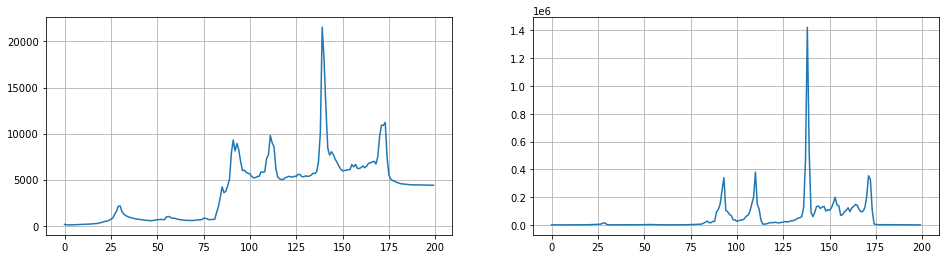

In [46]:
_ = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(arr_losses_3[:200,0])
plt.grid()
plt.subplot(1,2,2)
plt.plot(arr_losses_3[:200,1])
plt.grid()
plt.show()

In [47]:
pinn_4 = pinn_2.copy()
loss_stack_4 = [tu_loss.Observations(pinn_4,
                                     inputs_obs = dataset['obs_input'],
                                     outputs_obs = dataset['obs_output']),
                tu_loss.ASDM(pinn_4,
                             inputs_pde = dataset['pde'],
                             init_loss_weight = 1.0,
                             sigma_a = loss_stack_2[1].sigma_a.numpy()[0],
                             sigma_s = loss_stack_2[1].sigma_s.numpy()[0],
                             mu_a = loss_stack_2[1].mu_a.numpy()[0],
                             rho_a = loss_stack_2[1].rho_a.numpy()[0],
                             rho_s = loss_stack_2[1].rho_s.numpy()[0],
                            kappa_a = loss_stack_2[1].kappa_a.numpy()[0])
           ]

model_4 = tu.TINN(pinn_4, 
                  loss_stack_4, 
                  optimizer=keras.optimizers.SGD(learning_rate=1e-6),
                  #optimizer=keras.optimizers.Adam(),
                  fixed_loss_params=False,
                  fixed_pinn=False)

In [12]:
arr_losses_4, samples_params_4, _ = \
         model_4.train(10000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:530.33
Loss_observations:4.30424187 
Loss_ASDM:526.02992058 sigma_a:0:0.00971539, sigma_s:0:0.08769967, rho_a:0:1.80581951, rho_s:0:0.08867650, mu_a:0:1.80202341, kappa_a:0:0.25575227
Time:1.88

Epoch: 100, loss:451.21
Loss_observations:20.95087671 
Loss_ASDM:430.26112556 sigma_a:0:0.00721907, sigma_s:0:0.08803838, rho_a:0:1.80521119, rho_s:0:0.08883411, mu_a:0:1.80548608, kappa_a:0:0.25037014
Time:70.15

Epoch: 200, loss:437.64
Loss_observations:26.57062268 
Loss_ASDM:411.06728363 sigma_a:0:0.00484105, sigma_s:0:0.08798325, rho_a:0:1.80420542, rho_s:0:0.08820239, mu_a:0:1.80981684, kappa_a:0:0.24708562
Time:70.86

Epoch: 300, loss:431.11
Loss_observations:30.82690787 
Loss_ASDM:400.28688431 sigma_a:0:0.00358873, sigma_s:0:0.08752473, rho_a:0:1.80340016, rho_s:0:0.08734334, mu_a:0:1.81390977, kappa_a:0:0.24454433
Time:70.93

Epoch: 400, loss:427.31
Loss_observations:34.11659479 
Loss_ASDM:393.19693184 sigma_a:0:0.00307787, sigma_s:0:0.08692825, rho_a:0:1.80274487, rho_s:

KeyboardInterrupt: 